## Training a Loan Approval Model
### Objective
The objective of this notebook is to train a binary classification model that can predict fulfilment of loans and hence, automate loan approvals.

### 1. Exploratory Data Analysis

In [16]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from joblib import dump, load
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier

sns.set_theme(style="ticks", palette="pastel")

def remove_outliers(df, col: str):
    q3 = np.quantile(df[col], 0.75)
    q1 = np.quantile(df[col], 0.25)
    l_lmt = q1 - 1.5 * (q3 - q1)
    u_lmt = q3 + 1.5 * (q3 - q1)
    return df[(df[col] >= l_lmt) & (df[col] <= u_lmt)].copy()
    
#Read Sample Dataset
raw_df = pd.read_csv('../data/loan_dataset.csv')
raw_df.head()

,int_rate,emp_length,annual_inc,delinq_2yrs,fico_range_high,revol_bal,open_acc,loan_amnt,purpose,fully_paid
0,12.74,4 years,14000.0,0.0,689.0,9360.0,4.0,6150.0,credit_card,Yes
1,9.17,9 years,75000.0,0.0,679.0,16140.0,11.0,2000.0,debt_consolidation,Yes
2,10.99,10+ years,78000.0,0.0,729.0,23356.0,14.0,32000.0,credit_card,Yes
3,13.98,4 years,60000.0,0.0,679.0,20956.0,25.0,18000.0,debt_consolidation,No
4,19.99,< 1 year,35000.0,0.0,699.0,6848.0,5.0,4600.0,debt_consolidation,Yes


In [17]:
#Check number of records and columns
print(raw_df.shape)

(253195, 10)


In [18]:
#Check of missing values
raw_df.isnull().sum()

int_rate           0
emp_length         0
annual_inc         0
delinq_2yrs        0
fico_range_high    0
revol_bal          0
open_acc           0
loan_amnt          0
purpose            0
fully_paid         0
dtype: int64

In [19]:
raw_df.describe(include='all')

,int_rate,emp_length,annual_inc,delinq_2yrs,fico_range_high,revol_bal,open_acc,loan_amnt,purpose,fully_paid
count,253195.000000,253195,2.531950e+05,253195.000000,253195.000000,2.531950e+05,253195.000000,253195.000000,253195,253195
unique,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,14,2
top,NaN,10+ years,NaN,NaN,NaN,NaN,NaN,NaN,debt_consolidation,Yes
freq,NaN,88526,NaN,NaN,NaN,NaN,NaN,NaN,147207,203738
mean,13.233082,NaN,7.796567e+04,0.320733,700.129134,1.648344e+04,11.670357,14603.559904,NaN,NaN
std,4.770599,NaN,7.137296e+04,0.878757,31.660393,2.318867e+04,5.488765,8744.972160,NaN,NaN
min,5.310000,NaN,1.000000e+02,0.000000,664.000000,0.000000e+00,1.000000,500.000000,NaN,NaN
25%,9.750000,NaN,4.800000e+04,0.000000,674.000000,6.052000e+03,8.000000,8000.000000,NaN,NaN
50%,12.740000,NaN,6.500000e+04,0.000000,694.000000,1.131400e+04,11.000000,12150.000000,NaN,NaN
75%,15.990000,NaN,9.200000e+04,0.000000,714.000000,1.999050e+04,14.000000,20000.000000,NaN,NaN


In [20]:
def log_txf(df, cols: list):
    for col in cols:
        df['log_'+col] = np.log(df[col]+1)
    return df

raw_df = log_txf(raw_df, ['annual_inc','revol_bal'])
raw_df.describe(include='all')

,int_rate,emp_length,annual_inc,delinq_2yrs,fico_range_high,revol_bal,open_acc,loan_amnt,purpose,fully_paid,log_annual_inc,log_revol_bal
count,253195.000000,253195,2.531950e+05,253195.000000,253195.000000,2.531950e+05,253195.000000,253195.000000,253195,253195,253195.000000,253195.000000
unique,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,14,2,NaN,NaN
top,NaN,10+ years,NaN,NaN,NaN,NaN,NaN,NaN,debt_consolidation,Yes,NaN,NaN
freq,NaN,88526,NaN,NaN,NaN,NaN,NaN,NaN,147207,203738,NaN,NaN
mean,13.233082,NaN,7.796567e+04,0.320733,700.129134,1.648344e+04,11.670357,14603.559904,NaN,NaN,11.112571,9.212765
std,4.770599,NaN,7.137296e+04,0.878757,31.660393,2.318867e+04,5.488765,8744.972160,NaN,NaN,0.523922,1.202992
min,5.310000,NaN,1.000000e+02,0.000000,664.000000,0.000000e+00,1.000000,500.000000,NaN,NaN,4.615121,0.000000
25%,9.750000,NaN,4.800000e+04,0.000000,674.000000,6.052000e+03,8.000000,8000.000000,NaN,NaN,10.778977,8.708309
50%,12.740000,NaN,6.500000e+04,0.000000,694.000000,1.131400e+04,11.000000,12150.000000,NaN,NaN,11.082158,9.333885
75%,15.990000,NaN,9.200000e+04,0.000000,714.000000,1.999050e+04,14.000000,20000.000000,NaN,NaN,11.429555,9.903062


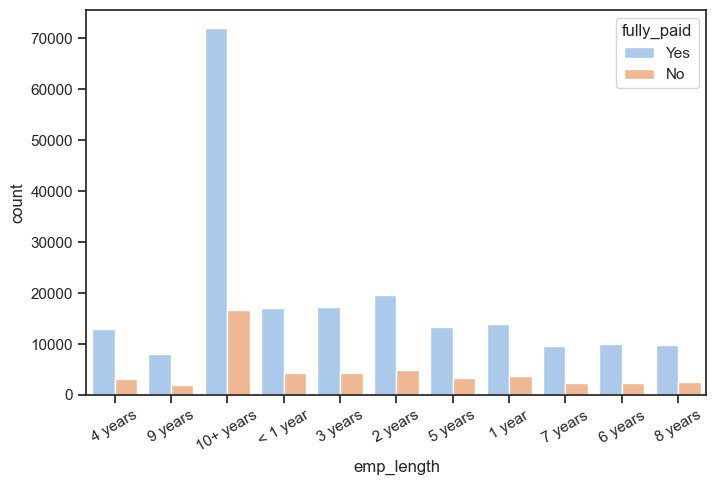

In [21]:
plt.figure(figsize=(8,5))
g = sns.countplot(raw_df, x="emp_length", hue="fully_paid")
g = g.set_xticklabels(g.get_xticklabels(), rotation=30)

d:\Workspace\Python\dssi-streamlit\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


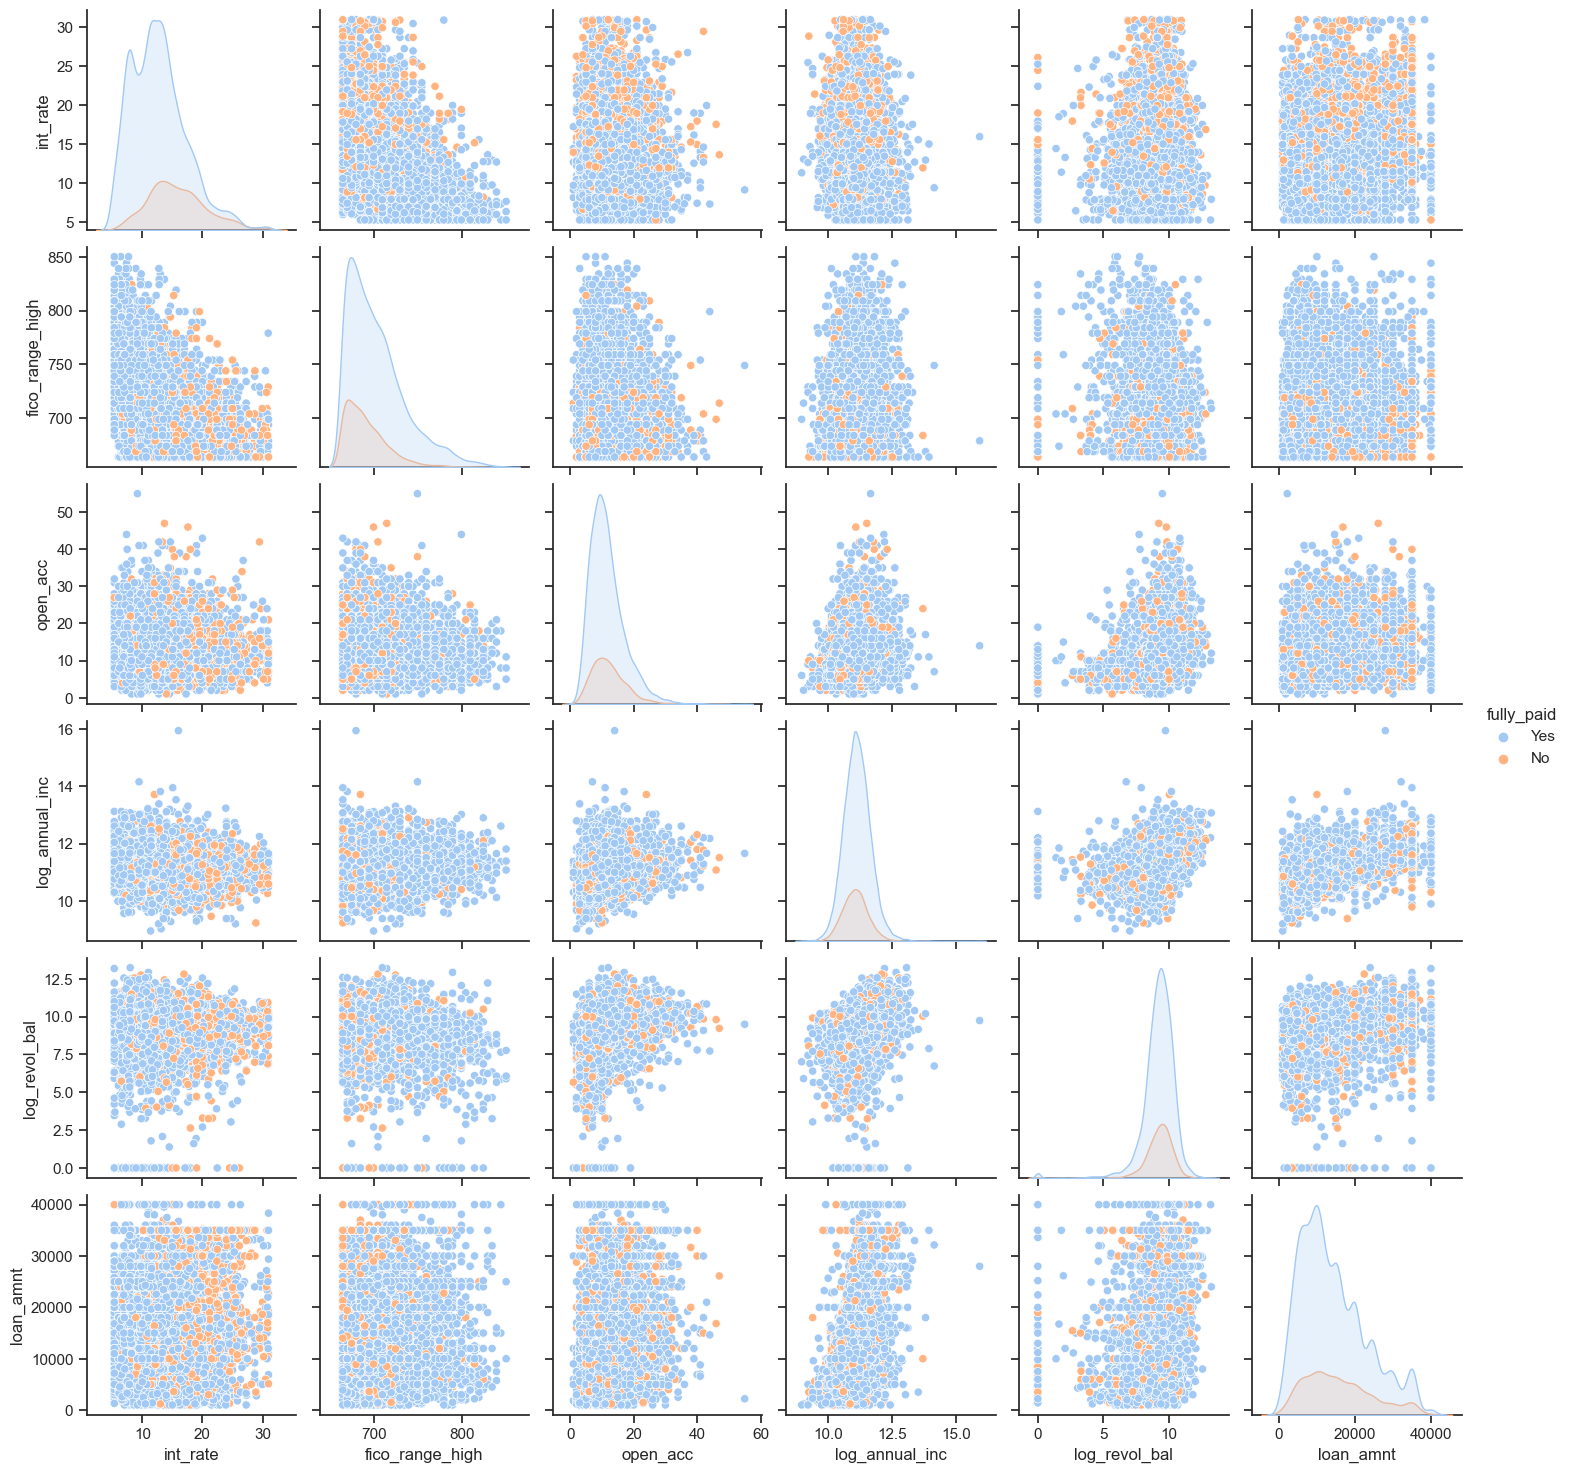

In [22]:
plt_df = raw_df.sample(frac=0.05)
g = sns.pairplot(plt_df[['int_rate','fico_range_high','open_acc','log_annual_inc','log_revol_bal','loan_amnt','fully_paid']], 
                 hue='fully_paid')

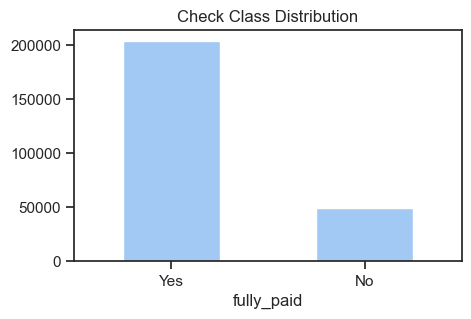

In [23]:
plt.figure(figsize=(5,3))
g = raw_df['fully_paid'].value_counts().plot.bar(title='Check Class Distribution', rot=0)

### 2. Feature Engineering

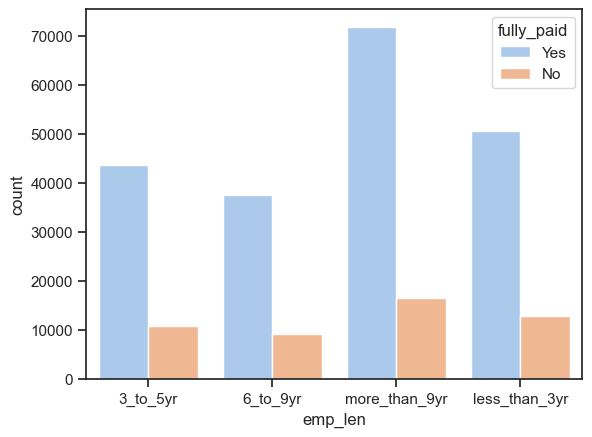

In [24]:
def remap_emp_length(x):
    if x in ['< 1 year','1 year','2 years']:
        return 'less_than_3yr'
    if x in ['3 years','4 years','5 years']:
        return '3_to_5yr'
    if x in ['6 years','7 years','8 years','9 years']:
        return '6_to_9yr'
    return 'more_than_9yr'

raw_df['emp_len'] = raw_df['emp_length'].map(remap_emp_length)
g = sns.countplot(raw_df, x="emp_len", hue="fully_paid")

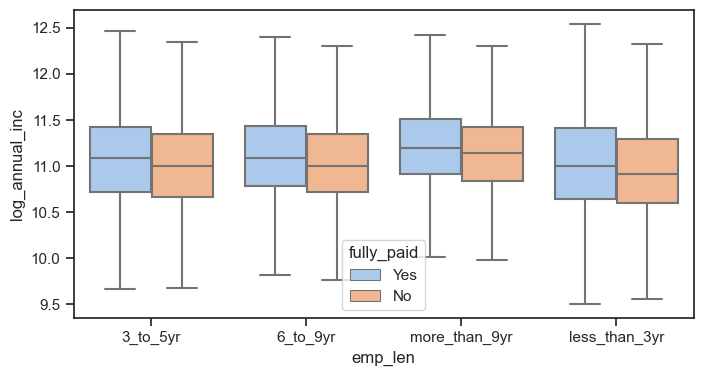

In [25]:
plt.figure(figsize=(8,4))
g = sns.boxplot(x="emp_len", y="log_annual_inc", hue="fully_paid", data=raw_df, showfliers = False)

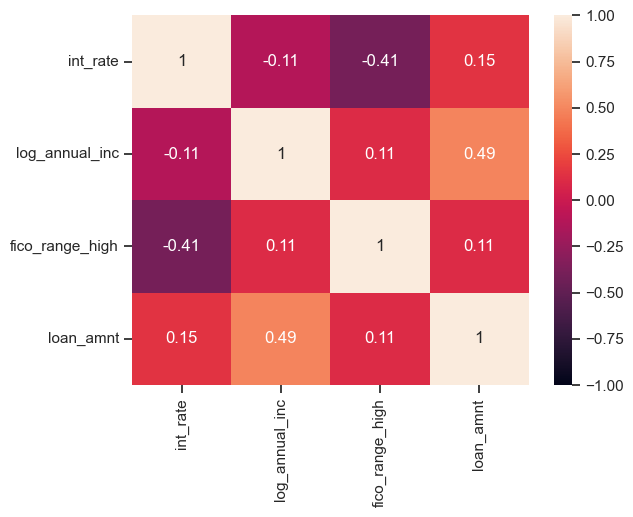

In [26]:
numeric_cols = ['int_rate','log_annual_inc','fico_range_high','loan_amnt']
g = sns.heatmap(raw_df[numeric_cols].corr(), vmin=-1, vmax=1, annot=True)

### 3. Data Preprocessing

In [27]:
#Select features that are discriminatory and uncorrelated
features = ['emp_len','int_rate','log_annual_inc','fico_range_high','loan_amnt']
numeric_features = ['int_rate','log_annual_inc','fico_range_high','loan_amnt']
categorical_features = ['emp_len']
label = 'fully_paid'

numeric_transformer = MinMaxScaler()

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

dat = preprocessor.fit_transform(raw_df)
new_cols = numeric_features + \
list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

trf_df = pd.DataFrame(dat, columns=new_cols)
trf_df.head()

,int_rate,log_annual_inc,fico_range_high,loan_amnt,emp_len_3_to_5yr,emp_len_6_to_9yr,emp_len_less_than_3yr,emp_len_more_than_9yr
0,0.289330,0.435337,0.134409,0.143038,1.0,0.0,0.0,0.0
1,0.150312,0.583490,0.080645,0.037975,0.0,1.0,0.0,0.0
2,0.221184,0.586952,0.349462,0.797468,0.0,0.0,0.0,1.0
3,0.337617,0.563793,0.080645,0.443038,1.0,0.0,0.0,0.0
4,0.571651,0.516216,0.188172,0.103797,0.0,0.0,1.0,0.0


### 4. Modeling
#### 4.1 Train-Test Split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(raw_df[features], \
                                                    raw_df[label], \
                                                    test_size=0.2, \
                                                    random_state=0)
X_train.head()

,emp_len,int_rate,log_annual_inc,fico_range_high,loan_amnt
144337,3_to_5yr,15.61,10.463132,684.0,8000.0
123917,3_to_5yr,12.99,11.082158,709.0,16000.0
90733,3_to_5yr,13.49,11.251574,689.0,8500.0
225466,6_to_9yr,18.99,10.580429,664.0,9600.0
132458,3_to_5yr,18.25,10.859018,669.0,22875.0


#### 4.2 Train Classifier

In [29]:
random_forest = RandomForestClassifier(n_estimators=100,
                                       max_depth=10, 
                                       class_weight = "balanced_subsample",
                                       n_jobs=2)

clf = Pipeline(steps=[("preprocessor", preprocessor),\
                      ("binary_classifier", random_forest)]
              )

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['int_rate', 'log_annual_inc',
                                                   'fico_range_high',
                                                   'loan_amnt']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['emp_len'])])),
                ('binary_classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=10, n_jobs=2))])

### 5. Evaluation

In [30]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

          No       0.31      0.66      0.42     10097
         Yes       0.88      0.63      0.74     40542

    accuracy                           0.64     50639
   macro avg       0.59      0.64      0.58     50639
weighted avg       0.77      0.64      0.67     50639

